In [1]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [2]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors

In [3]:
DATA_DIR = '../input/conll-corpora/conll2000/conll2000/{}.txt'

def get_data(file):
    with open(file, 'r', encoding='latin1') as fp:
        content = fp.readlines()
    data, sent = [], []
    for line in content:
        if not line.strip():
            if sent: data.append(sent)
            sent = []
        else:
            word, pos, tag = line.strip().split()
            tag = tag.split('-')[0]
            sent.append((word, pos, tag))
    return data

In [4]:
train_data = get_data(DATA_DIR.format('train'))
test_data = get_data(DATA_DIR.format('test'))

In [5]:
MAX_LEN = 78
empty_token = '<UNK>'
empty_pos = '^'
empty_tag = '$'
pad_value = 0
embed_dim = 300

In [6]:
sentences_train = [' '.join([tup[0].lower() for tup in sent]) for sent in train_data]
sent_tokenizer = Tokenizer(oov_token=empty_token, filters='\t\n') 
sent_tokenizer.fit_on_texts(sentences_train)
sentences_train = sent_tokenizer.texts_to_sequences(sentences_train)
sentences_train = pad_sequences(sentences_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_WORDS = len(sent_tokenizer.word_index)

sentences_test = [' '.join([tup[0].lower() for tup in sent]) for sent in test_data]
sentences_test = sent_tokenizer.texts_to_sequences(sentences_test)
sentences_test = pad_sequences(sentences_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [7]:
postags_train = [' '.join([tup[1].lower() for tup in sent]) for sent in train_data]
pos_tokenizer = Tokenizer(oov_token=empty_pos, filters='\t\n') 
pos_tokenizer.fit_on_texts(postags_train)
postags_train = pos_tokenizer.texts_to_sequences(postags_train)
postags_train = pad_sequences(postags_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_POS = len(pos_tokenizer.word_index)

postags_test = [' '.join([tup[1].lower() for tup in sent]) for sent in test_data]
postags_test = pos_tokenizer.texts_to_sequences(postags_test)
postags_test = pad_sequences(postags_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [8]:
tags_train = [[tup[2] for tup in sent] for sent in train_data]
tag_tokenizer = Tokenizer(oov_token=empty_tag, filters='\t\n')
tag_tokenizer.fit_on_texts(tags_train)
tags_train = tag_tokenizer.texts_to_sequences(tags_train)
tags_train = pad_sequences(tags_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_TAGS = len(tag_tokenizer.word_index)

tags_test = [[tup[2] for tup in sent] for sent in test_data]
tags_test = tag_tokenizer.texts_to_sequences(tags_test)
tags_test = pad_sequences(tags_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [9]:
def load_glove():
    file = f'../input/nlpword2vecembeddingspretrained/glove.6B.{embed_dim}d.txt'
    embeddings_index = dict()
    f = open(file)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = np.mean(all_embs), np.std(all_embs)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (NUM_WORDS + 1, embed_dim))
    embeddedCount = 0
    not_found = []
    for word, idx in sent_tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector
            embeddedCount += 1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    del(all_embs)
    return embedding_matrix

def load_word2vec():
    file = '../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin'
    word2vec = KeyedVectors.load_word2vec_format(file, binary=True)
    embedding_matrix = np.random.normal(size=(NUM_WORDS + 1, embed_dim))
    for word, idx in sent_tokenizer.word_index.items():
        if word in word2vec.vocab:
            embedding_matrix[idx] = word2vec.word_vec(word)
    return embedding_matrix

In [10]:
glove = load_glove()

Loaded 400000 word vectors.
total embedded: 15794 common words


In [20]:
# wvec = load_word2vec()

In [35]:
def ignore_accuracy_of_class(class_to_ignore=0):
    def acc(y_true, y_pred):
        y_true_class=tf.cast(y_true, tf.int64)
        y_pred_class = K.argmax(y_pred, axis=-1)
        ignore_mask = K.cast(K.not_equal(y_pred_class, class_to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return acc

custom_acc = ignore_accuracy_of_class(pad_value)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Concatenate

def model_without_pos():
    with strategy.scope():
        custom_emb = keras.initializers.Constant(glove)
        regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)
        inputs = Input(shape=(MAX_LEN,), dtype='int32')
        word_emb = Embedding(NUM_WORDS + 1, embed_dim, embeddings_initializer=custom_emb, trainable=True)(inputs)
        lstm = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizer))(word_emb)
        td = TimeDistributed(Dense(NUM_TAGS + 1, activation='softmax', kernel_regularizer=regularizer))(lstm)
        model = Model(inputs=[inputs], outputs=[td])
        return model
    
def model_with_pos():
    with strategy.scope():
        custom_emb = keras.initializers.Constant(glove)
        regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)
        word_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        pos_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        word_emb = Embedding(NUM_WORDS + 1, embed_dim, embeddings_initializer=custom_emb, trainable=True)(word_inputs)
        pos_emb = Embedding(NUM_POS + 1, 25, trainable=True)(pos_inputs)
        emb = Concatenate(axis=-1)([word_emb, pos_emb])
        lstm = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizer))(emb)
        td = TimeDistributed(Dense(NUM_TAGS + 1, activation='softmax', kernel_regularizer=regularizer))(lstm)
        model = Model(inputs=[word_inputs, pos_inputs], outputs=[td])
        return model

In [37]:
K.clear_session()
model = model_without_pos()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 78)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 78, 300)           5178000   
_________________________________________________________________
bidirectional (Bidirectional (None, 78, 64)            85248     
_________________________________________________________________
time_distributed (TimeDistri (None, 78, 5)             325       
Total params: 5,263,573
Trainable params: 5,263,573
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

losses, val_losses = [], []
accs, val_accs = [], []
model_name = 'bilstm_chunker.h5'
stopper = EarlyStopping(monitor='acc', patience=5, mode='max')
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_acc', mode='max', save_best_only=True, verbose=2)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=[custom_acc])

In [39]:
history = model.fit(
    x = sentences_train,
    y = tags_train,
    validation_data = (sentences_test, tags_test),
    callbacks = [stopper],
    epochs = 60,
    batch_size = 128 * strategy.num_replicas_in_sync,
    verbose = 1,
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

accs += list(history.history['acc'])
val_accs += list(history.history['val_acc'])

Epoch 1/60
9/9 [==============================] - 6s 671ms/step - acc: 0.5212 - loss: 1.4985 - val_acc: 0.5308 - val_loss: 1.2322
Epoch 2/60
9/9 [==============================] - 1s 65ms/step - acc: 0.5399 - loss: 1.1696 - val_acc: 0.5346 - val_loss: 1.0967
Epoch 3/60
9/9 [==============================] - 1s 60ms/step - acc: 0.5419 - loss: 1.0492 - val_acc: 0.5429 - val_loss: 0.9923
Epoch 4/60
9/9 [==============================] - 1s 60ms/step - acc: 0.5779 - loss: 0.9547 - val_acc: 0.6083 - val_loss: 0.9071
Epoch 5/60
9/9 [==============================] - 1s 62ms/step - acc: 0.6253 - loss: 0.8734 - val_acc: 0.6295 - val_loss: 0.8306
Epoch 6/60
9/9 [==============================] - 1s 64ms/step - acc: 0.6527 - loss: 0.7997 - val_acc: 0.6617 - val_loss: 0.7610
Epoch 7/60
9/9 [==============================] - 1s 64ms/step - acc: 0.6810 - loss: 0.7324 - val_acc: 0.6882 - val_loss: 0.6971
Epoch 8/60
9/9 [==============================] - 1s 60ms/step - acc: 0.7147 - loss: 0.6704 - va

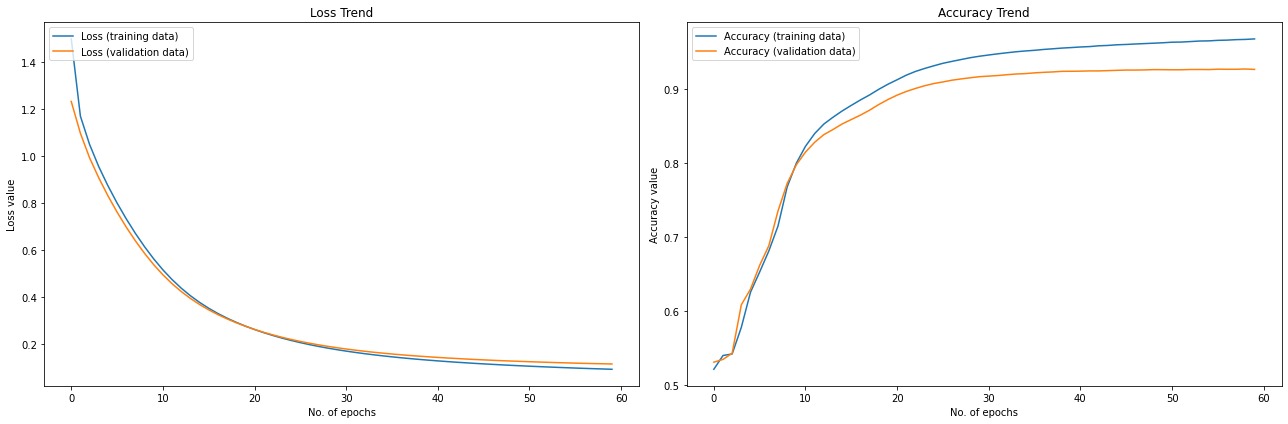

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(losses, label='Loss (training data)')
ax[0].plot(val_losses, label='Loss (validation data)')
ax[0].set_title('Loss Trend')
ax[0].set_ylabel('Loss value')
ax[0].set_xlabel('No. of epochs')
ax[0].legend(loc="upper left")

ax[1].plot(accs, label='Accuracy (training data)')
ax[1].plot(val_accs, label='Accuracy (validation data)')
ax[1].set_title('Accuracy Trend')
ax[1].set_ylabel('Accuracy value')
ax[1].set_xlabel('No. of epochs')
ax[1].legend(loc="upper left")

plt.tight_layout()

plt.savefig('loss_acc_trend.png', bbox_inches='tight')
plt.show()

In [43]:
def pred_labels(sentences_test, tags_test, given_model):
    tags_pred = np.argmax(given_model.predict(sentences_test), axis=-1)
    y_true, y_pred = [], []
    inv_map = {v:k for k,v in tag_tokenizer.word_index.items()}
    for i in range(len(tags_test)):
        for j in range(len(tags_test[i])):
            # we have reached padding
            if tags_test[i][j] == pad_value : 
                break
            # map padding class to $ class
            if tags_pred[i][j] == pad_value :
                tags_pred[i][j] = tag_tokenizer.word_index[empty_tag]
            y_pred.append(inv_map[tags_pred[i][j]].upper())
            y_true.append(inv_map[tags_test[i][j]].upper())
    return np.array(y_true), np.array(y_pred)

In [44]:
y_true, y_pred = pred_labels(sentences_test, tags_test, model)

In [45]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag == pred:
            correct[tag] += 1
        else:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    thresh = 1 / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)
    thresh = np.max(plotMat) / 2
    thresh = 1 / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()

In [46]:
classes = sorted([c.upper() for c in tag_tokenizer.word_index.keys() if c != empty_tag])
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)

<Figure size 432x288 with 0 Axes>

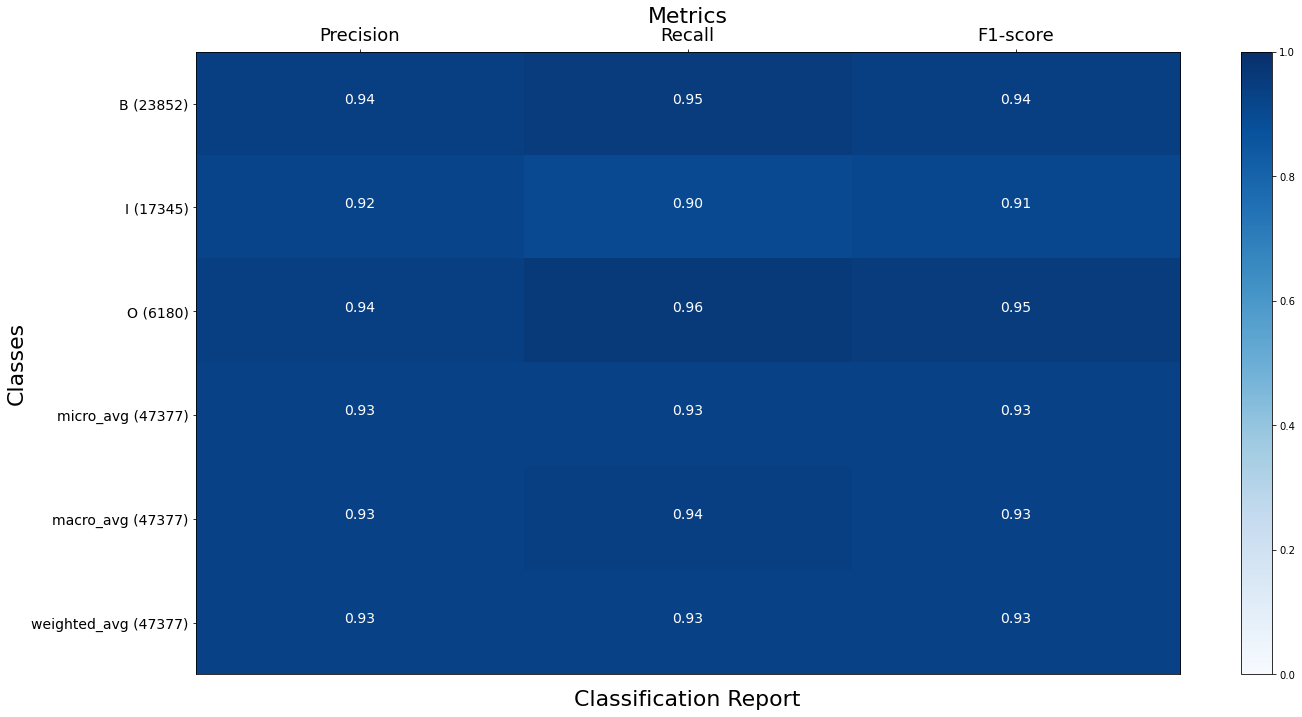

In [47]:
plot_clf_report(class_names, report, support)

<Figure size 432x288 with 0 Axes>

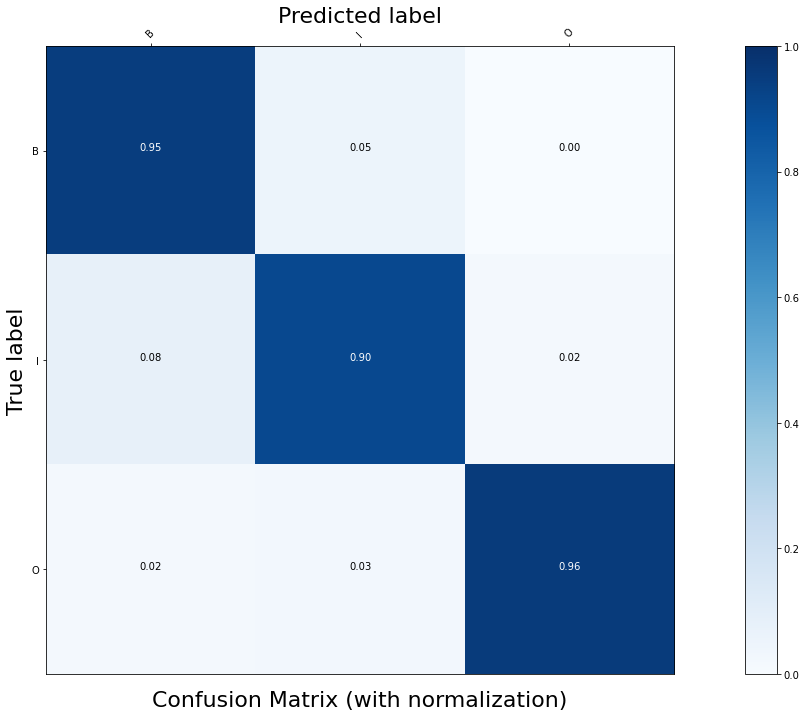

In [48]:
plot_confusion_matrix(classes, cm)

<Figure size 432x288 with 0 Axes>

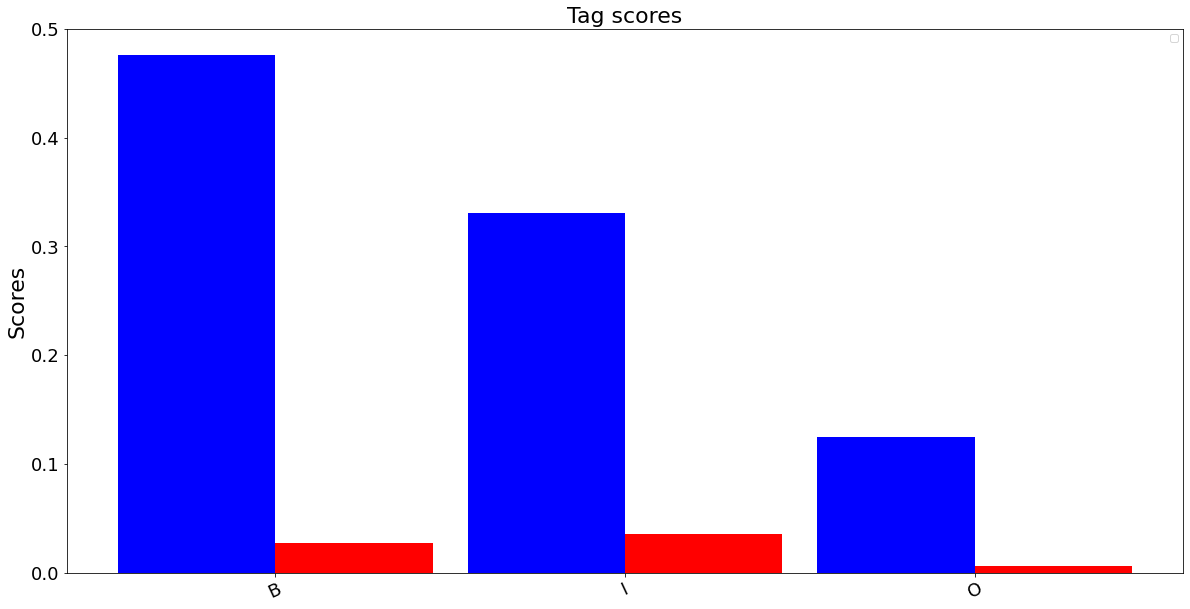

In [49]:
plot_tag_scores(classes, scores)